In [12]:
import numpy as np
import matplotlib.pyplot as plt
import PIL

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy

from PIL import Image

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-09-21 17:26:24,099: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
test_image = Image.open('test_4x4_image.tif')
np_test_image = np.array(test_image)

test_image_final = []
for row in np_test_image:
    for pixel in row:
        test_image_final.append( pixel[0] / 256)

np_test_image_final = np.array(test_image_final)

np_test_image_final_reshaped = np_test_image_final.reshape((4,4))
print(np_test_image_final_reshaped)


[[0.8125     0.84765625 0.86328125 0.8515625 ]
 [0.88671875 0.89453125 0.22265625 0.8984375 ]
 [0.2890625  0.890625   0.49609375 0.8984375 ]
 [0.43359375 0.89453125 0.38671875 0.4375    ]]


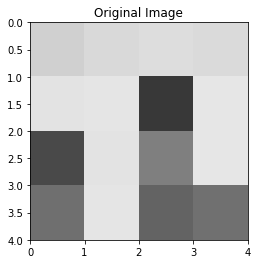

In [4]:
def plot_image4x4(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image4x4(np_test_image_final_reshaped, "Original Image")   

[[0.2778443  0.2898664  0.29520956 0.29120219]
 [0.3032243  0.30589588 0.07614002 0.30723167]
 [0.09884845 0.30456009 0.16964532 0.30723167]
 [0.14827268 0.30589588 0.1322432  0.14960847]]


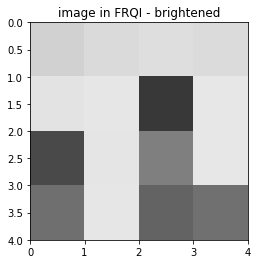

In [5]:
def normalize(array):
    rms = np.sqrt(np.sum(np.sum(array**2)))
    ret_array = []
    for i in array:
        ret_array.append( (i * (1/rms)) )
    
    npret_array = np.array(ret_array)
    return npret_array

def plot_image4x4_brightened(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=0.34, cmap='gray')
    plt.show()
    

np_test_image_final_reshaped_normalized = normalize(np_test_image_final_reshaped)
print(np_test_image_final_reshaped_normalized)

plot_image4x4_brightened(np_test_image_final_reshaped_normalized, 'image in FRQI - brightened')

In [6]:
def decrement():
    qdec = QuantumCircuit(5)
    for i in range(5):
        qdec.x(i)
    
    qdec.mct([0,1,2,3],4)
    qdec.mct([0,1,2],3)
    qdec.ccx(0,1,2)
    qdec.cx(0,1)
    qdec.x(0)
    
    for i in range(5):
        qdec.x(i)
    
    qdec = qdec.to_gate()
    qdec.name = "Decrement"
    
    return qdec

[0.27784429575556685, 0.28986640470652886, 0.29520956424028977, 0.2912021945899691, 0.3032243035409311, 0.3058958833078116, 0.07614002335609284, 0.30723167319125183, 0.09884845137457667, 0.30456009342437135, 0.16964531519690862, 0.30723167319125183, 0.148272677061865, 0.3058958833078116, 0.1322431984605823, 0.14960846694530522]


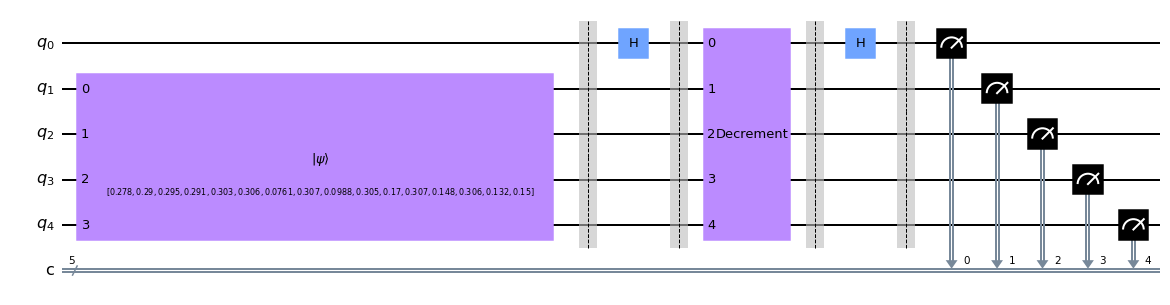

In [9]:
# We can hence use initialize() on actual quantum hardware.
# Let's set up the first iteration of the qGaussian algorithm:
initial_state = []

for row in np_test_image_final_reshaped_normalized:
    for pixel in row:
        initial_state.append(pixel)

print(initial_state)

qc_1 = QuantumCircuit(5,5)
qc_1.initialize(initial_state,[1,2,3,4])
qc_1.barrier()

qc_1.h(0)
qc_1.barrier()

qc_1.append(decrement(), [0,1,2,3,4])
qc_1.barrier()

qc_1.h(0)
qc_1.barrier()

qc_1.measure([0,1,2,3,4], [0,1,2,3,4])

qc_1.draw()


In [8]:
# Running on actual Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (5) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_qc_1 = transpile(qc_1, backend, optimization_level=3)
job_1 = backend.run(transpiled_qc_1)
job_monitor(job_1, interval=2)

ibmqfactory.load_account:WARNING:2022-09-15 11:36:43,974: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_manila
Job Status: job has been cancelled


In [13]:
qr = QuantumRegister(4)
qc = QuantumCircuit(qr)
qc.initialize(initial_state, [qr[0], qr[1], qr[2], qr[3]]).gates_to_uncompute().draw()

Traceback (most recent call last):
  Input In [13] in <cell line: 3>
    qc.initialize(initial_state, [qr[0], qr[1], qr[2], qr[3]]).gates_to_uncompute().draw()
AttributeError: 'InstructionSet' object has no attribute 'gates_to_uncompute'

Use %tb to get the full traceback.


In [9]:
print(job_1.result().get_counts())

Traceback (most recent call last):
  Input In [9] in <cell line: 1>
    print(job_1.result().get_counts())
  File /opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/job/ibmqjob.py:279 in result
    raise IBMQJobInvalidStateError('Unable to retrieve result for job {}. '
IBMQJobInvalidStateError: 'Unable to retrieve result for job 63230e57bf82611be300a040. Job was cancelled.'

Use %tb to get the full traceback.


In [37]:
qc_1_job_1_results = job_1.result().get_counts()
qc_1_job_1_results_relevant = {qubit_order: shots for qubit_order, shots in qc_1_job_1_results.items() if qubit_order[4] == '0'}
print(qc_1_job_1_results_relevant)

{'00000': 136, '10000': 132, '10010': 155, '10100': 142, '10110': 158, '11000': 94, '11010': 99, '11100': 98, '11110': 98, '00010': 143, '00100': 160, '00110': 192, '01000': 73, '01010': 77, '01100': 95, '01110': 97}


In [52]:
get_bin = lambda x, n: format(x, 'b').zfill(n)

print(qc_1_job_1_results_relevant)

qc_1_job_1_results_relevant_counts = [ qc_1_job_1_results_relevant[get_bin(i,5)[::-1]] for i in range(2**4)]  
print(qc_1_job_1_results_relevant_counts)

{'00000': 136, '10000': 132, '10010': 155, '10100': 142, '10110': 158, '11000': 94, '11010': 99, '11100': 98, '11110': 98, '00010': 143, '00100': 160, '00110': 192, '01000': 73, '01010': 77, '01100': 95, '01110': 97}
[136, 132, 73, 94, 160, 142, 95, 98, 143, 155, 77, 99, 192, 158, 97, 98]


In [56]:
np_qc_1_job_1_results_relevant_counts = np.array(qc_1_job_1_results_relevant_counts)
np_qc_1_job_1_results_relevant_counts_normalized = normalize(np_qc_1_job_1_results_relevant_counts)

print(np_qc_1_job_1_results_relevant_counts)
print(np_qc_1_job_1_results_relevant_counts_normalized)

np_qc_1_job_1_results_relevant_counts_normalized_reshaped = np_qc_1_job_1_results_relevant_counts_normalized.reshape((4,4))
print(np_qc_1_job_1_results_relevant_counts_normalized_reshaped)

[136 132  73  94 160 142  95  98 143 155  77  99 192 158  97  98]
[0.26904437 0.2611313  0.14441352 0.18595714 0.31652279 0.28091398
 0.18793541 0.19387021 0.28289224 0.30663145 0.15232659 0.19584848
 0.37982735 0.31256625 0.19189194 0.19387021]
[[0.26904437 0.2611313  0.14441352 0.18595714]
 [0.31652279 0.28091398 0.18793541 0.19387021]
 [0.28289224 0.30663145 0.15232659 0.19584848]
 [0.37982735 0.31256625 0.19189194 0.19387021]]


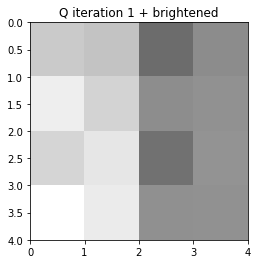

In [58]:
plot_image4x4_brightened(np_qc_1_job_1_results_relevant_counts_normalized_reshaped, "Q iteration 1 + brightened")

[0.2778443  0.2898664  0.29520956 0.29120219 0.3032243  0.30589588
 0.07614002 0.30723167 0.09884845 0.30456009 0.16964532 0.30723167
 0.14827268 0.30589588 0.1322432  0.14960847]
0.27784429575556685
[0.2778443  0.2898664  0.29520956 0.29120219 0.3032243  0.30589588
 0.07614002 0.30723167 0.09884845 0.30456009 0.16964532 0.30723167
 0.14827268 0.30589588 0.1322432  0.14960847 0.2778443 ]
[0.5677107  0.58507597 0.58641176 0.5944265  0.60912019 0.38203591
 0.3833717  0.40608012 0.40340854 0.47420541 0.47687699 0.45550435
 0.45416856 0.43813908 0.28185167 0.42745276]
[[0.2961981  0.30525828 0.30595522 0.31013684]
 [0.31780314 0.1993239  0.20002084 0.21186876]
 [0.21047489 0.24741253 0.24880641 0.23765542]
 [0.23695848 0.22859524 0.14705365 0.22301975]]


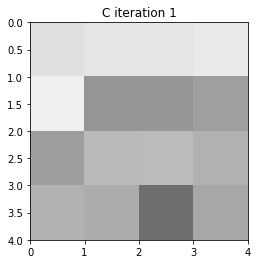

In [8]:
classical_iteration_1 = []
np_temp_image_iteration_0 = np_test_image_final_reshaped_normalized.reshape(16)
print(np_temp_image_iteration_0)
print(np_temp_image_iteration_0[0])

np_temp_image_iteration_0_appended = np.append(np_temp_image_iteration_0, np_temp_image_iteration_0[0])
print(np_temp_image_iteration_0_appended)

for i in range(2**4):
    classical_iteration_1.append(np_temp_image_iteration_0_appended[i] + np_temp_image_iteration_0_appended[i + 1])

np_classical_iteration_1 = np.array(classical_iteration_1)
print(np_classical_iteration_1)

np_classical_iteration_1_normalized = normalize(np_classical_iteration_1)
np_classical_iteration_1_normalized_reshaped = np_classical_iteration_1_normalized.reshape((4,4))

print(np_classical_iteration_1_normalized_reshaped)


plot_image4x4_brightened(np_classical_iteration_1_normalized_reshaped, "C iteration 1")  


In [9]:
#Running on a simulator:
# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
qc = transpile(qc_1, simulator)

# Run and get statevector
result = simulator.run(qc).result()
counts = result.get_counts()

print(counts)

{'11001': 3, '11011': 6, '01101': 15, '10100': 49, '01110': 53, '11100': 25, '11110': 35, '00010': 78, '10101': 9, '10000': 38, '11010': 45, '00100': 73, '10011': 6, '00110': 83, '01011': 10, '00000': 91, '01000': 124, '11111': 5, '10110': 66, '10010': 66, '10001': 10, '01010': 34, '01111': 8, '10111': 8, '11000': 60, '01100': 24}


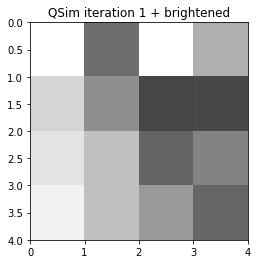

In [11]:
qc_1_sim_results = counts
qc_1_sim_results_relevant = {qubit_order: shots for qubit_order, shots in qc_1_sim_results.items() if qubit_order[4] == '0'}

get_bin = lambda x, n: format(x, 'b').zfill(n)

qc_1_sim_results_relevant_counts = [ qc_1_sim_results_relevant[get_bin(i,5)[::-1]] for i in range(2**4)]  

np_qc_1_sim_results_relevant_counts = np.array(qc_1_sim_results_relevant_counts)
np_qc_1_sim_results_relevant_counts_normalized = normalize(np_qc_1_sim_results_relevant_counts)

np_qc_1_sim_results_relevant_counts_normalized_reshaped = np_qc_1_sim_results_relevant_counts_normalized.reshape((4,4))

plot_image4x4_brightened(np_qc_1_sim_results_relevant_counts_normalized_reshaped, "QSim iteration 1 + brightened")

[0.27784429575556685, 0.28986640470652886, 0.29520956424028977, 0.2912021945899691, 0.3032243035409311, 0.3058958833078116, 0.07614002335609284, 0.30723167319125183, 0.09884845137457667, 0.30456009342437135, 0.16964531519690862, 0.30723167319125183, 0.148272677061865, 0.3058958833078116, 0.1322431984605823, 0.14960846694530522]


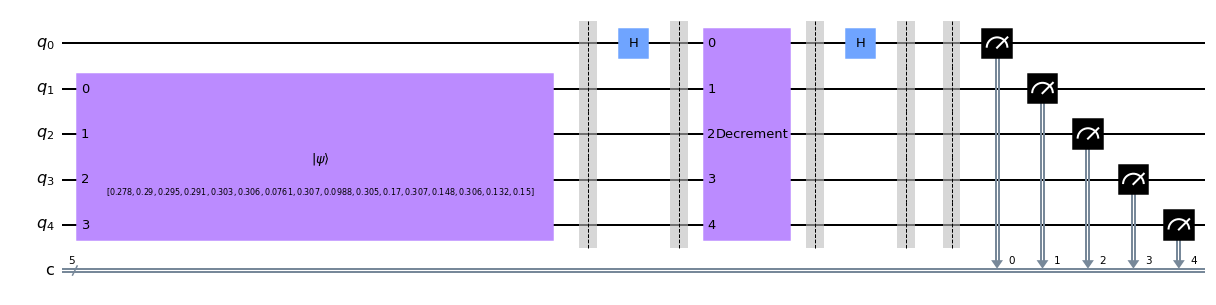

In [9]:
# We can hence use initialize() on actual quantum hardware.
# Let's set up the first iteration of the qGaussian algorithm:
initial_state = []

for row in np_test_image_final_reshaped_normalized:
    for pixel in row:
        initial_state.append(pixel)

print(initial_state)

qc_1 = QuantumCircuit(5,5)
qc_1.initialize(initial_state,[1,2,3,4])
qc_1.barrier()

qc_1.h(0)
qc_1.barrier()

qc_1.append(decrement(), [0,1,2,3,4])
qc_1.barrier()

qc_1.h(0)
qc_1.barrier()

qc_1.save_statevector()

qc_1.measure([0,1,2,3,4], [0,1,2,3,4])

qc_1.draw()



In [10]:
# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
qc_1_statevector = transpile(qc_1, simulator)

# Run and get statevector
result_qc_1_statevector = simulator.run(qc_1_statevector).result()
statevector = result_qc_1_statevector.get_statevector(qc_1_statevector)
print(statevector)

Statevector([ 0.28385535-1.77491982e-17j, -0.00601105+1.77491982e-17j,
              0.29253798-1.80763724e-17j, -0.00267158+1.80763724e-17j,
              0.29320588-1.78309918e-17j,  0.00200368+1.78309918e-17j,
              0.29721325-1.85671336e-17j, -0.00601105+1.85671336e-17j,
              0.30456009-1.87307207e-17j, -0.00133579+1.87307207e-17j,
              0.19101795-4.66223179e-18j,  0.11487793+4.66223179e-18j,
              0.19168585-1.88125143e-17j, -0.11554582+1.88125143e-17j,
              0.20304006-6.05272198e-18j,  0.10419161+6.05272198e-18j,
              0.20170427-1.86489272e-17j, -0.10285582+1.86489272e-17j,
              0.2371027 -1.03877796e-17j,  0.06745739+1.03877796e-17j,
              0.23843849-1.88125143e-17j, -0.06879318+1.88125143e-17j,
              0.22775218-9.07908297e-18j,  0.0794795 +9.07908297e-18j,
              0.22708428-1.87307207e-17j, -0.0788116 +1.87307207e-17j,
              0.21906954-8.09756049e-18j,  0.08682634+8.09756049e-18j,
      

In [11]:
iteration1 = []
for i in range(2**5):
    if(i % 2 == 0):
        iteration1.append(np.real(statevector[i]))
        
#print(iteration1)

npiteration1 = np.array(iteration1)
npiteration1 = normalize(npiteration1)
npiteration1 = npiteration1.reshape((4,4))

print(npiteration1)

[[0.2961981  0.30525828 0.30595522 0.31013684]
 [0.31780314 0.1993239  0.20002084 0.21186876]
 [0.21047489 0.24741253 0.24880641 0.23765542]
 [0.23695848 0.22859524 0.14705365 0.22301975]]


[0.27784429575556685, 0.28986640470652886, 0.29520956424028977, 0.2912021945899691, 0.3032243035409311, 0.3058958833078116, 0.07614002335609284, 0.30723167319125183, 0.09884845137457667, 0.30456009342437135, 0.16964531519690862, 0.30723167319125183, 0.148272677061865, 0.3058958833078116, 0.1322431984605823, 0.14960846694530522]


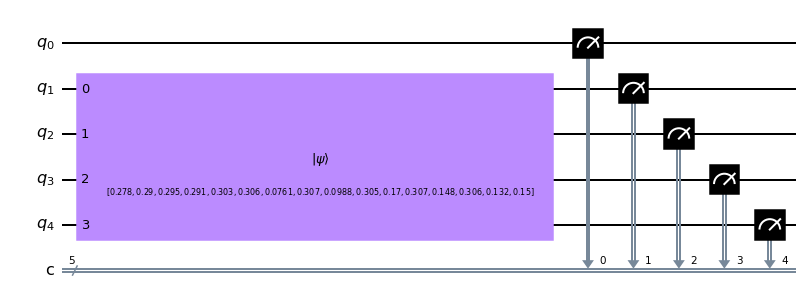

In [50]:
#Ok let's try to just get our image our and see if it works properly.
qc_image = QuantumCircuit(5,5)

initial_state = []

for row in np_test_image_final_reshaped_normalized:
    for pixel in row:
        initial_state.append(pixel)

print(initial_state)

qc_image.initialize(initial_state, [1,2,3,4])

qc_image.measure([0,1,2,3,4], [0,1,2,3,4])

qc_image.draw()


In [8]:
#Running on a simulator:
simulator = Aer.get_backend('aer_simulator')
qc_image_transpiled = transpile(qc_image, simulator)

# Run and get statevector
result = simulator.run(qc_image_transpiled).result()
counts = result.get_counts()

print(counts)

plot_histogram(counts)

Traceback (most recent call last):
  Input In [8] in <cell line: 3>
    qc_image_transpiled = transpile(qc_image, simulator)
NameError: name 'qc_image' is not defined

Use %tb to get the full traceback.


{'0110': 10, '1100': 27, '0101': 107, '1101': 94, '0111': 93, '0000': 66, '1110': 19, '1010': 33, '1011': 104, '1111': 19, '1000': 8, '0001': 82, '0011': 101, '0010': 86, '1001': 78, '0100': 97}
[[0.2538762  0.28298079 0.28980058 0.31405861]
 [0.30777681 0.32325251 0.09882118 0.30136409]
 [0.08838835 0.27599253 0.17951758 0.31868872]
 [0.16237976 0.30297999 0.13621559 0.13621559]]


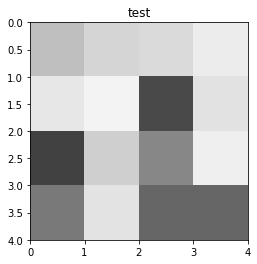

In [65]:
qc_image_sim_results = counts
qc_image_sim_results_relevant = {qubit_order[:-1:]: shots for qubit_order, shots in qc_image_sim_results.items() if qubit_order[4] == '0'}

print(qc_image_sim_results_relevant)

get_bin = lambda x, n: format(x, 'b').zfill(n)
qc_image_sim_results_relevant_counts = [ qc_image_sim_results_relevant[get_bin(i,4)] for i in range(2**4)] 

np_image_counts_2 = np.array(qc_image_sim_results_relevant_counts)
np_image_counts_2 = np_image_counts_2 / 4096
np_image_counts_2 = np.sqrt(np_image_counts_2)
np_image_counts_2 = normalize(np_image_counts_2)

np_image_counts_2_reshaped = np_image_counts_2.reshape((4,4))

print(np_image_counts_2_reshaped)

plot_image4x4_brightened(np_image_counts_2_reshaped, "test")

In [59]:


np_qc_image_sim_results_relevant_counts = np.array(qc_image_sim_results_relevant_counts)
print(np_qc_image_sim_results_relevant_counts)
np_qc_image_sim_results_relevant_counts_normalized = normalize(np_qc_image_sim_results_relevant_counts)

np_qc_image_sim_results_relevant_counts_normalized_reshaped = np_qc_image_sim_results_relevant_counts_normalized.reshape((4,4))

#plot_image4x4_brightened(np_qc_1_sim_results_relevant_counts_normalized_reshaped, "QSim iteration 1 + brightened")

[ 69  11  99  22  83  33   9  17  89  94 104  99  95  85  96  19]


[0.27784429575556685, 0.28986640470652886, 0.29520956424028977, 0.2912021945899691, 0.3032243035409311, 0.3058958833078116, 0.07614002335609284, 0.30723167319125183, 0.09884845137457667, 0.30456009342437135, 0.16964531519690862, 0.30723167319125183, 0.148272677061865, 0.3058958833078116, 0.1322431984605823, 0.14960846694530522]


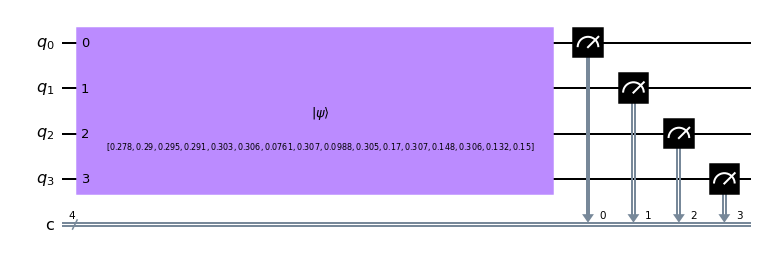

In [9]:
#Ok let's try to just get our image our and see if it works properly.
qc_image = QuantumCircuit(4,4)

initial_state = []

for row in np_test_image_final_reshaped_normalized:
    for pixel in row:
        initial_state.append(pixel)

print(initial_state)

qc_image.initialize(initial_state, [0,1,2,3])

qc_image.measure([0,1,2,3], [0,1,2,3])

qc_image.draw()


{'1110': 15, '0110': 7, '0100': 94, '0010': 82, '0001': 80, '1011': 107, '1111': 22, '1010': 32, '1001': 87, '1100': 27, '0101': 93, '1000': 12, '1101': 98, '0000': 91, '0011': 88, '0111': 89}


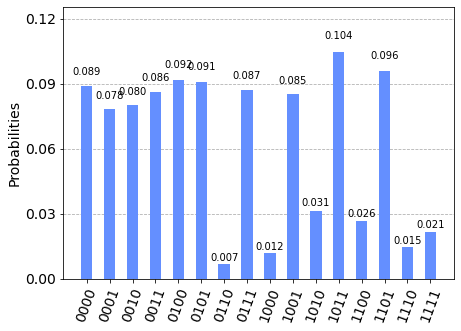

In [7]:
#Running on a simulator:
simulator = Aer.get_backend('aer_simulator')
qc_image_transpiled = transpile(qc_image, simulator)

# Run and get statevector
result = simulator.run(qc_image_transpiled).result()
counts = result.get_counts()

print(counts)

plot_histogram(counts)

[[0.31061096 0.27306458 0.27989119 0.30037104]
 [0.32085088 0.31743757 0.02389315 0.30378435]
 [0.04095969 0.29695773 0.10922583 0.36522388]
 [0.0921593  0.33450411 0.05119961 0.07509276]]


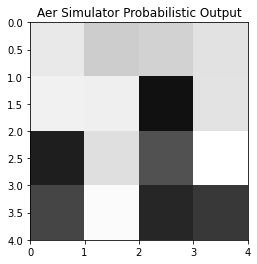

In [21]:
get_bin = lambda x, n: format(x, 'b').zfill(n)

image_counts = [counts[get_bin(i,4)] for i in range(2**4)] 

np_image_counts = np.array(image_counts)
np_image_counts = np_image_counts / 1024
np_image_counts = normalize(np_image_counts)

np_image_counts_reshaped = np_image_counts.reshape((4,4))

print(np_image_counts_reshaped)

plot_image4x4_brightened(np_image_counts_reshaped, "Aer Simulator Probabilistic Output")

{'1000': 30, '0010': 330, '1110': 80, '1101': 357, '1010': 109, '1111': 89, '0110': 18, '0100': 353, '0001': 389, '1100': 103, '0101': 390, '1001': 394, '1011': 397, '0011': 346, '0000': 320, '0111': 391}


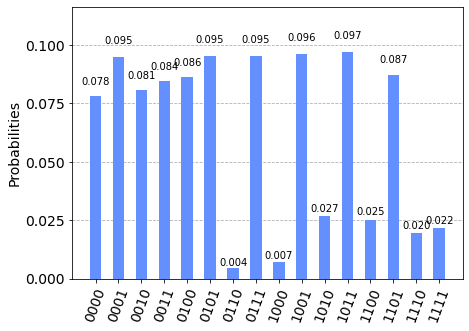

In [47]:
#Running on a simulator:
simulator = Aer.get_backend('aer_simulator')
qc_image_transpiled = transpile(qc_image, simulator)

# Run and get statevector
result = simulator.run(qc_image_transpiled, shots=4096).result()
counts_1 = result.get_counts()

print(counts_1)

plot_histogram(counts_1)

[[0.2795085  0.30817317 0.28384222 0.2906418 ]
 [0.2935671  0.30856903 0.06629126 0.30896437]
 [0.08558165 0.31014739 0.16312979 0.31132592]
 [0.15857643 0.29522568 0.13975425 0.14740596]]


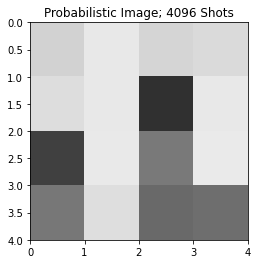

In [49]:
get_bin = lambda x, n: format(x, 'b').zfill(n)

image_counts_1 = [counts_1[get_bin(i,4)] for i in range(2**4)] 

np_image_counts_1 = np.array(image_counts_1)
np_image_counts_1 = np_image_counts_1 / 4096
np_image_counts_1 = np.sqrt(np_image_counts_1)
np_image_counts_1 = normalize(np_image_counts_1)

np_image_counts_1_reshaped = np_image_counts_1.reshape((4,4))

print(np_image_counts_1_reshaped)

plot_image4x4_brightened(np_image_counts_1_reshaped, "Probabilistic Image; 4096 Shots")

In [7]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
belem = provider.get_backend('ibmq_belem')
job_results = belem.retrieve_job('632342b128d98bbf0f844ef2')
print(job_results.result().get_counts())

ibmqfactory.load_account:WARNING:2022-09-16 13:33:33,667: Credentials are already in use. The existing account in the session will be replaced.


{'00000': 110, '00001': 114, '10000': 138, '10001': 157, '10010': 147, '10011': 133, '10100': 181, '10101': 166, '10110': 169, '10111': 151, '11000': 150, '11001': 142, '11010': 134, '11011': 142, '11100': 161, '11101': 147, '11110': 142, '11111': 113, '00010': 81, '00011': 90, '00100': 128, '00101': 123, '00110': 110, '00111': 80, '01000': 100, '01001': 99, '01010': 77, '01011': 87, '01100': 119, '01101': 116, '01110': 90, '01111': 103}


In [10]:
# Running on Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (4) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_qc_image = transpile(qc_image, backend, optimization_level=3)
job_image = backend.run(transpiled_qc_image)
job_monitor(job_image, interval=2)

ibmqfactory.load_account:WARNING:2022-09-16 14:41:50,655: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_belem
Job Status: job has successfully run


In [17]:
job_image_results = job_image.result().get_counts()
print(job_image_results)

{'0000': 582, '0001': 410, '0010': 96, '0011': 87, '0100': 543, '0101': 391, '0110': 110, '0111': 102, '1000': 429, '1001': 396, '1010': 97, '1011': 79, '1100': 285, '1101': 282, '1110': 71, '1111': 40}


[[0.38144462 0.32015621 0.15491933 0.14747881]
 [0.36844267 0.31264996 0.16583124 0.15968719]
 [0.32749046 0.31464265 0.15572412 0.14053469]
 [0.26692696 0.26551836 0.13322913 0.1       ]]


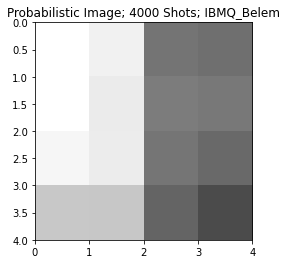

In [19]:
get_bin = lambda x, n: format(x, 'b').zfill(n)

image_counts_1 = [job_image_results[get_bin(i,4)] for i in range(2**4)] 

np_image_counts_1 = np.array(image_counts_1)
np_image_counts_1 = np_image_counts_1 / 4096
np_image_counts_1 = np.sqrt(np_image_counts_1)
np_image_counts_1 = normalize(np_image_counts_1)

np_image_counts_1_reshaped = np_image_counts_1.reshape((4,4))

print(np_image_counts_1_reshaped)

plot_image4x4_brightened(np_image_counts_1_reshaped, "Probabilistic Image; 4000 Shots; IBMQ_Belem")